In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

## 将瞳孔数据分组

In [2]:
# 读取文件
pupil_data = pd.read_pickle("./pupil_data.pd")
pupil_event = pd.read_pickle("./pupil_event.pd")

In [3]:
pupil_data

,pupil_size,pupil_x,pupil_y
timestamp,,,
2021-11-04 08:07:50.855,96,1387.22,391.002
2021-11-04 08:07:50.865,95,1386.48,391.712
2021-11-04 08:07:50.875,96,1385.55,392.301
2021-11-04 08:07:50.885,97,1385.65,394.228
2021-11-04 08:07:50.895,97,1384.57,394.236
...,...,...,...
2021-11-04 09:01:45.984,99,1353.21,442.819
2021-11-04 09:01:45.994,100,1352.92,442.970
2021-11-04 09:01:46.004,99,1352.76,442.369


In [4]:
pupil_event

message
trail_id timestamp                                                 
1        2021-11-04 08:07:50.862                          TRIALID 1
         2021-11-04 08:07:52.364  !V TRIAL_VAR transitions variable
         2021-11-04 08:07:52.865               !V TRIAL_VAR stake 5
         2021-11-04 08:07:54.011      !E TRIAL_EVENT_VAR response_1
         2021-11-04 08:07:54.872    !E TRIAL_EVENT_VAR monster_show
...                                                             ...
294      2021-11-04 09:01:39.890      !E TRIAL_EVENT_VAR response_1
         2021-11-04 09:01:41.034    !E TRIAL_EVENT_VAR monster_show
         2021-11-04 09:01:41.850      !E TRIAL_EVENT_VAR response_2
         2021-11-04 09:01:43.035          !E TRIAL_EVENT_VAR reward
         2021-11-04 09:01:46.027                          TRIAL_END

[2352 rows x 1 columns]

In [5]:
trail_num = len(pupil_event.index.levels[0])

In [6]:
trail_num

294

## 0.Utils

数据分割

In [7]:
def get_trail_segment(num_list:list):
    '''
    给定trail_num,返回分割后的pupil_data和pupil_event,需要以列表的形式，如果只有一个元素，也需要是列表
    '''
    for num in num_list:
        assert 1<= num <= trail_num, f"the legal trail_num between 1 and {trail_num},check the input "
    # 开始时间应该是trail的开始时间
    # 结束时间是下一个trail的开始时间
    ans_pupil_data = pd.DataFrame()
    ans_pupil_event = pd.DataFrame()
    for num in num_list:
        temp = pupil_event.loc[num].index
        start_time,end_time = temp[0],temp[-1]
        # 筛选时间段
        ans_pupil_data = ans_pupil_data.append(pupil_data[start_time:end_time])
        ans_pupil_event = ans_pupil_event.append(pupil_event.loc[num])
    return ans_pupil_data,ans_pupil_event

In [8]:
ans_pupil_data_1,ans_pupil_event_1 = get_trail_segment(range(1,5))
test_time_start = ans_pupil_data_1.index[0]
test_time_end = ans_pupil_data_1.index[-1]

计算频率

In [56]:
fs = 0

In [86]:
fs = 0
def set_fs(df):
    fs = len(df)/(df.index[-1]-df.index[0]).value*10e8
    fs = int(round(fs,0))
    return fs
    

In [87]:
fs  = set_fs(pupil_data)
fs

100

In [78]:
# 原型函数
# fs = len(pupil_data)/(pupil_data.index[-1]-pupil_data.index[0]).value

In [83]:
2

2000000.0

In [63]:
(pupil_data.index[-1]-pupil_data.index[0])

Timedelta('0 days 00:53:55.169000')

In [ ]:
3180000

In [66]:
(pupil_data.index[-1]-pupil_data.index[0]).value/100000

32351690.0

## 0. 对数据进行滤波

数据滤波直接决定了分析的好坏，是必须要进行的分析方法  
这里提供多种分析方法，同时会对操作方法进行记录，方便复现与脚本运行

支持的滤波方式如下  
1. butterworth filter
2. FIR
3. 移动平均滤波(参考博客2，可以进行多种滤波)
4. 中值滤波
5. 维纳滤波
6. 自适应滤波
7. 小波滤波

### 1. 滤波前的图片

<AxesSubplot:xlabel='timestamp'>

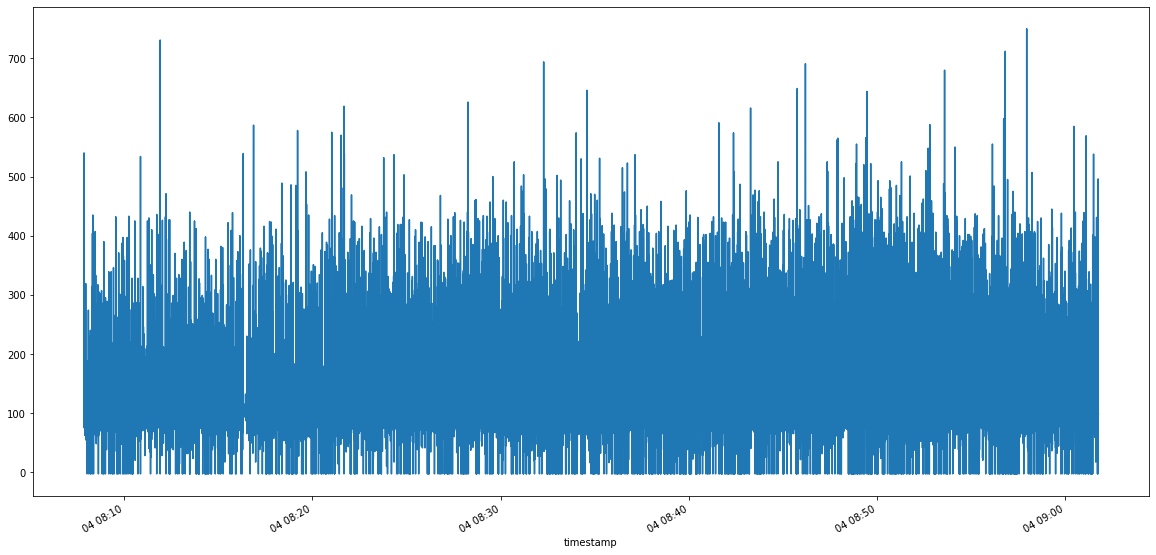

In [9]:
plt.figure(figsize=(20,10))
pupil_data['pupil_size'].plot()

### 原先的效果

<AxesSubplot:xlabel='timestamp'>

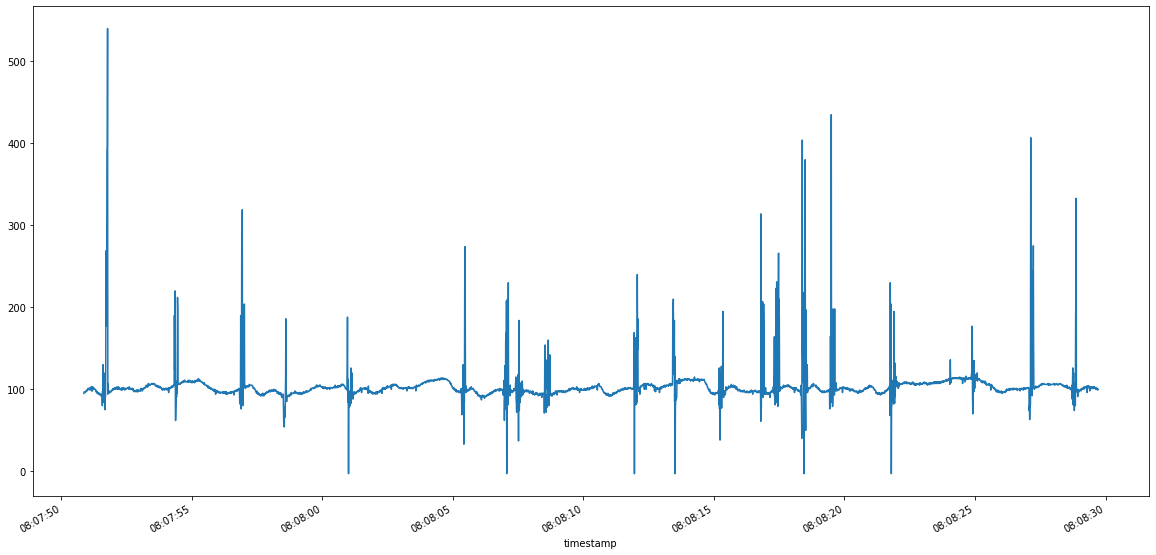

In [24]:
plt.figure(figsize=(20,10))
pupil_data[test_time_start:test_time_end]['pupil_size'].plot()

## 滤波1——移动平均滑窗

In [25]:
# 是否需要改名为SMA？
def move_average(df,window_size = 5):
    return df.rolling(window = wondow_size).sum()

<AxesSubplot:xlabel='timestamp'>

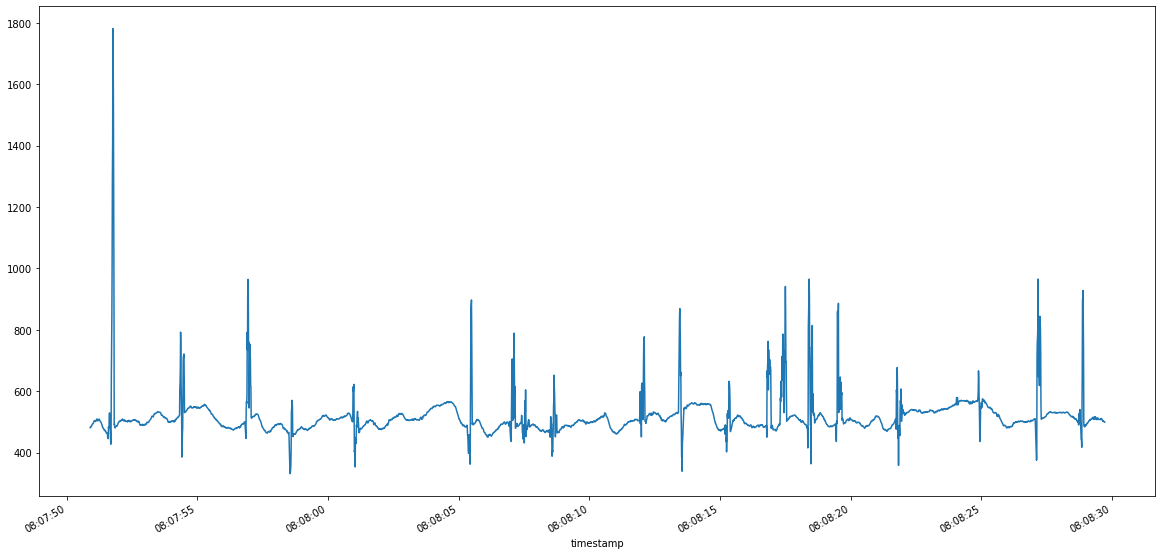

In [28]:
b = pupil_data[test_time_start:test_time_end].rolling(window = 5).sum()
plt.figure(figsize=(20,10))
b['pupil_size'].plot()

## 滤波2——赫尔移动平均

In [50]:
# https://stackoverflow.com/questions/64500904/how-to-calculate-hull-moving-average-in-python
def WMA(s, period):
       return s.rolling(period).apply(lambda x: ((np.arange(period)+1)*x).sum()/(np.arange(period)+1).sum(), raw=True)

def HMA(s, period):
       return WMA(WMA(s, period//2).multiply(2).sub(WMA(s, period)), int(np.sqrt(period)))

In [51]:
def HMA_pupil(df,period):
    
    return HMA(WMA(df["pupil_size"],period),period)
    

In [54]:
a = HMA_pupil(pupil_data[test_time_start:test_time_end],period = 10)

<AxesSubplot:xlabel='timestamp'>

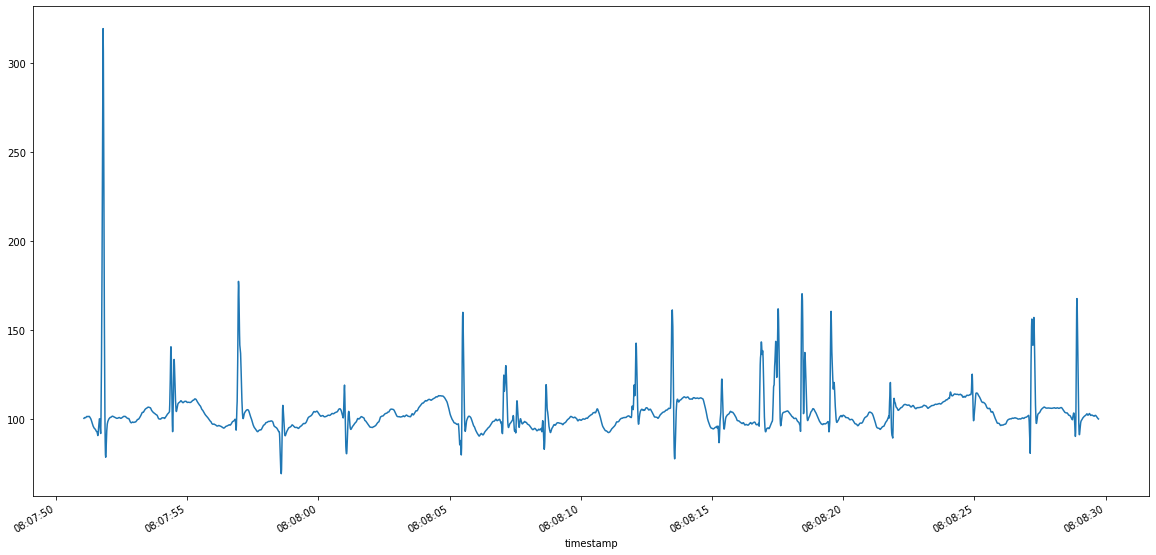

In [55]:
plt.figure(figsize=(20,10))
a.plot()

In [11]:
a = pupil_data[test_time_start:test_time_end].rolling(window = 5).sum()

<AxesSubplot:xlabel='timestamp'>

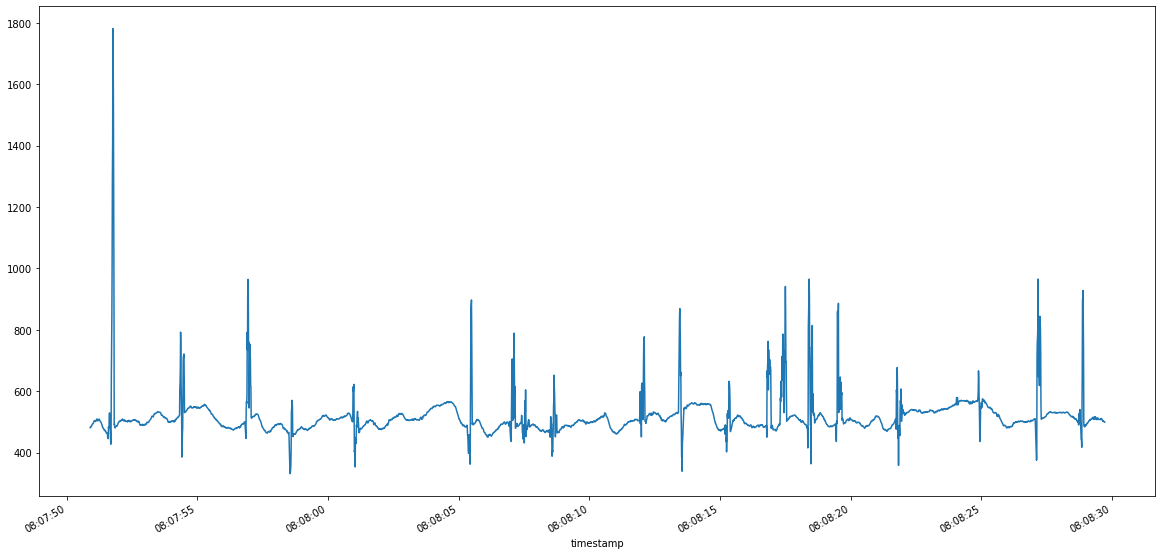

In [14]:
plt.figure(figsize=(20,10))
a['pupil_size'].plot()

*总结*  
效果不错，但是平均移动不适合我们的设备，噪声非常的而厉害，还是建议带通滤波  
而且平均滤波会对数据产生滞后，对分析刺激因素的时候造成障碍，所以不建议

## 滤波3——巴特沃斯

In [89]:
fs  = set_fs(pupil_data)
fs

100

In [90]:
# 1.确定数据范围[test_time_start:test_time_end]
# 2.确定频率fs
fs  = set_fs(pupil_data[test_time_start:test_time_end])
fs
# 3. 确定阶数（需要不断循环，找到合适的）

100

DatetimeIndex(['2021-11-04 08:07:50.865000', '2021-11-04 08:07:50.875000',
               '2021-11-04 08:07:50.885000', '2021-11-04 08:07:50.895000',
               '2021-11-04 08:07:50.905000', '2021-11-04 08:07:50.915000',
               '2021-11-04 08:07:50.925000', '2021-11-04 08:07:50.935000',
               '2021-11-04 08:07:50.945000', '2021-11-04 08:07:50.955000',
               ...
               '2021-11-04 08:08:29.636000', '2021-11-04 08:08:29.646000',
               '2021-11-04 08:08:29.656000', '2021-11-04 08:08:29.666000',
               '2021-11-04 08:08:29.676000', '2021-11-04 08:08:29.686000',
               '2021-11-04 08:08:29.696000', '2021-11-04 08:08:29.706000',
               '2021-11-04 08:08:29.716000', '2021-11-04 08:08:29.726000'],
              dtype='datetime64[ns]', name='timestamp', length=3887, freq=None)

In [132]:
temp  =  pupil_data[test_time_start:test_time_end].copy()

<AxesSubplot:xlabel='timestamp'>

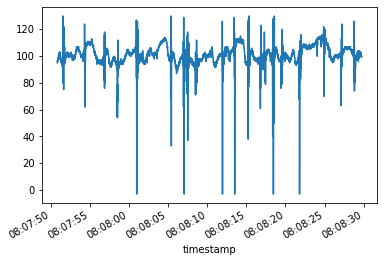

<AxesSubplot:xlabel='timestamp'>

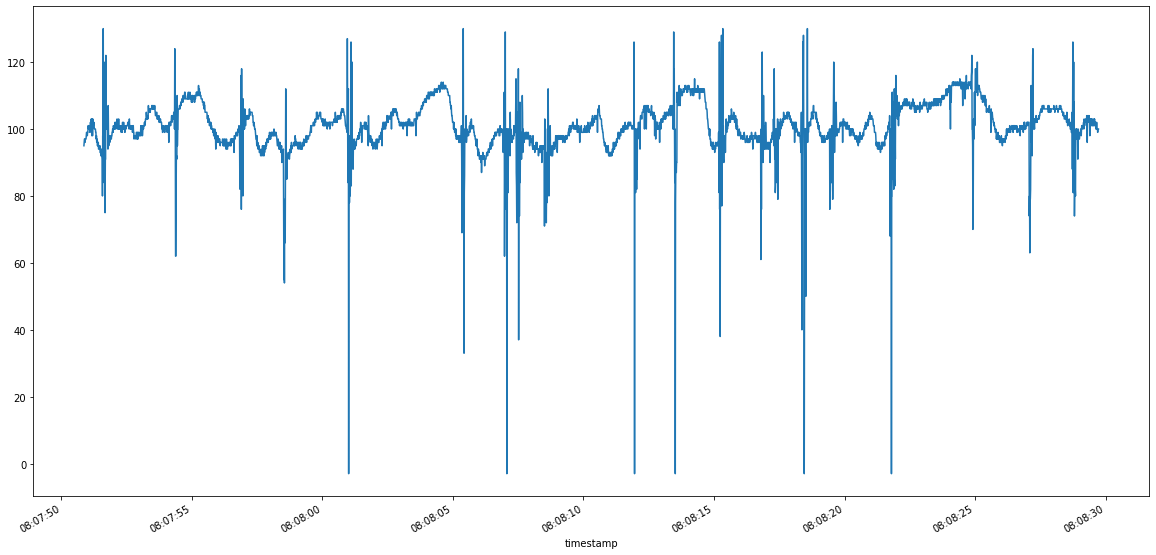

In [140]:
plt.figure(figsize=(20,10))
temp[temp[temp.columns[0]]>130] =100
temp["pupil_size"].plot()

<AxesSubplot:xlabel='timestamp'>

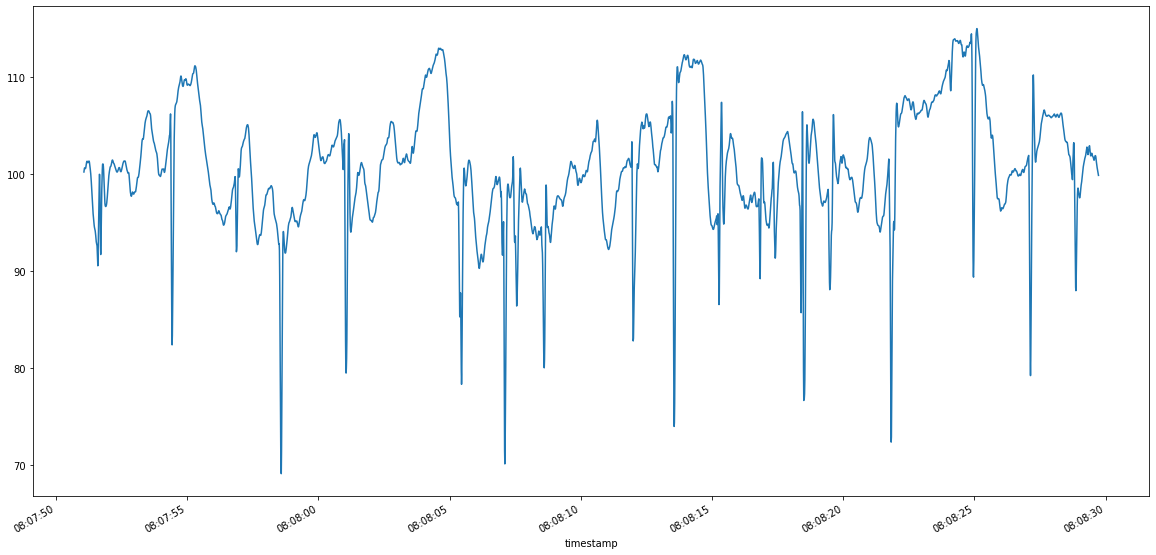

In [141]:
a = HMA_pupil(temp[test_time_start:test_time_end],period = 10)
plt.figure(figsize=(20,10))
a.plot()

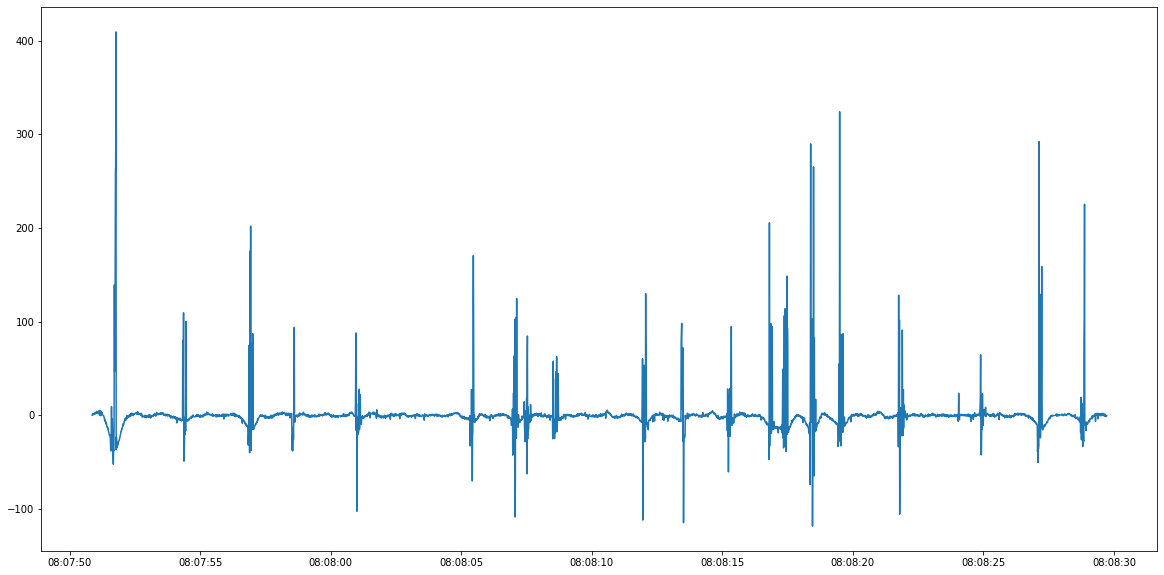

In [157]:
order = 2
cutoff = 1
normal_cutoff = 2*cutoff/fs
b, a = signal.butter(order, normal_cutoff, btype='highpass', analog=False)
y = signal.filtfilt(b, a, pupil_data[test_time_start:test_time_end]["pupil_size"].values)
plt.figure(figsize=(20,10))
plt.plot(pupil_data[test_time_start:test_time_end]["pupil_size"].index,y)

In [170]:
temp_raw = pupil_data[test_time_start:test_time_end]["pupil_size"].values
temp_ans = temp_raw - y

In [162]:
temp_ans

array([ 94.87260685,  94.99671871,  95.12068601, ..., 100.33956009,
       100.30338686, 100.2681784 ])

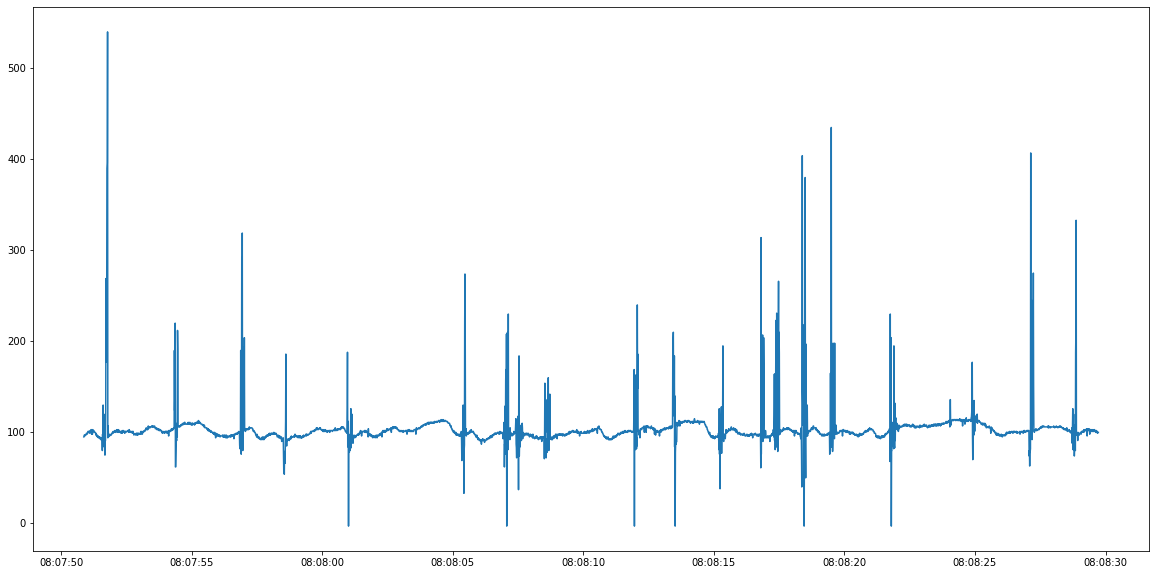

In [171]:
plt.figure(figsize=(20,10))
plt.plot(pupil_data[test_time_start:test_time_end]["pupil_size"].index,temp_raw)

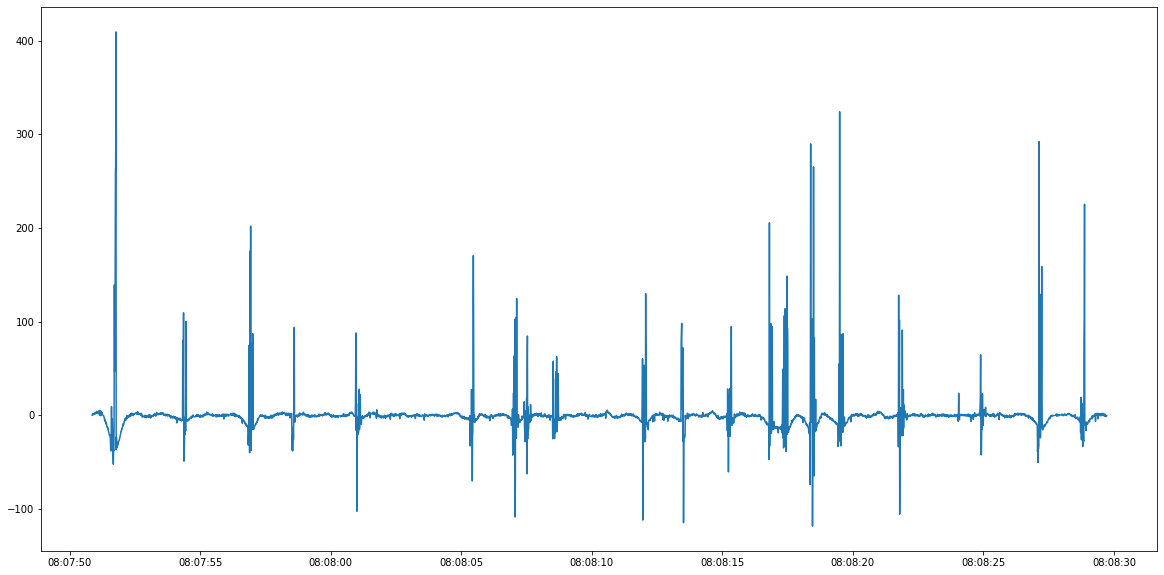

In [173]:
plt.figure(figsize=(20,10))
plt.plot(pupil_data[test_time_start:test_time_end]["pupil_size"].index,y)

In [ ]:
plt.plot(pupil_data[test_time_start:test_time_end]["pupil_size"].index,y)

In [176]:
temp_ans = temp_raw - y

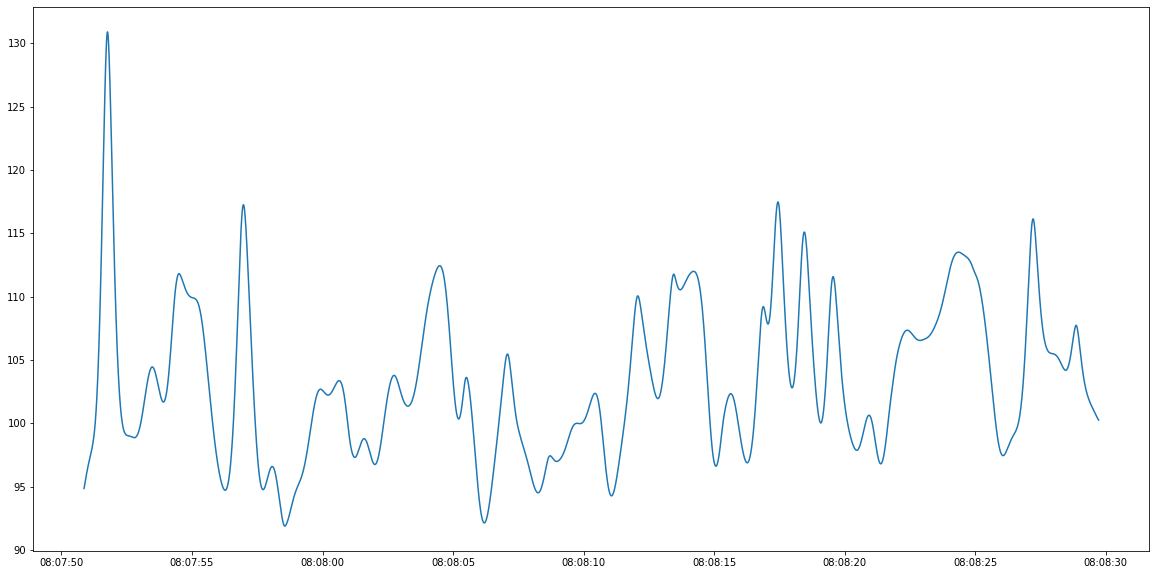

In [179]:
plt.figure(figsize=(20,10))
plt.plot(pupil_data[test_time_start:test_time_end]["pupil_size"].index,temp_ans)

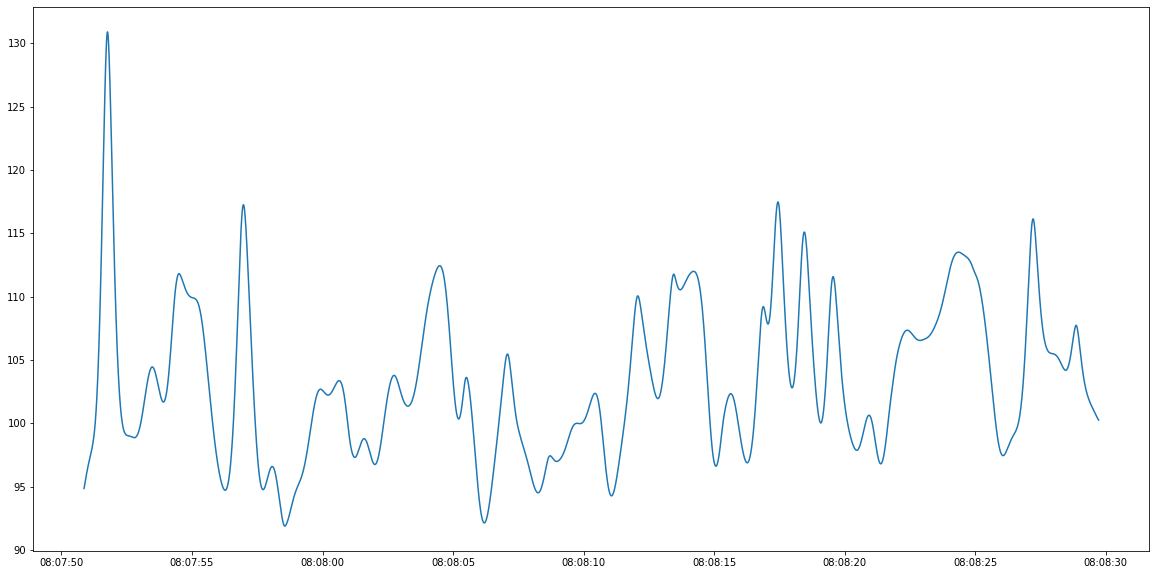

In [178]:
plt.figure(figsize=(20,10))
plt.plot(pupil_data[test_time_start:test_time_end]["pupil_size"].index,temp_ans)

In [ ]:
a = HMA_pupil(pupil_data[test_time_start:test_time_end],period = 10)

## 策略——先单独选出高频数据，再从原始数据中删除高频数据

<AxesSubplot:xlabel='timestamp'>

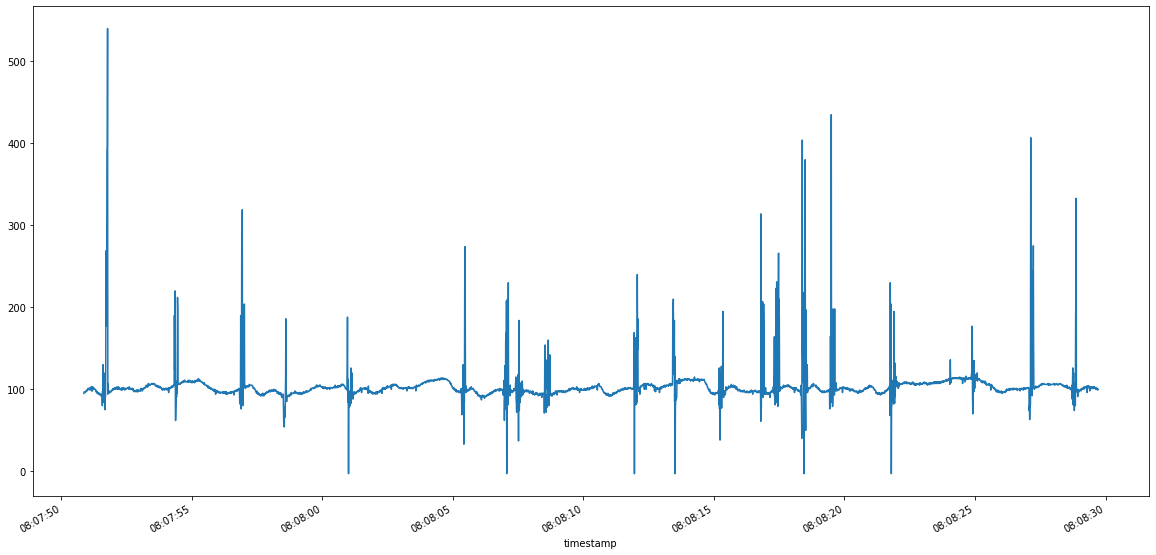

In [182]:
plt.figure(figsize=(20,10))
pupil_data[test_time_start:test_time_end]["pupil_size"].plot()

展示高频数据

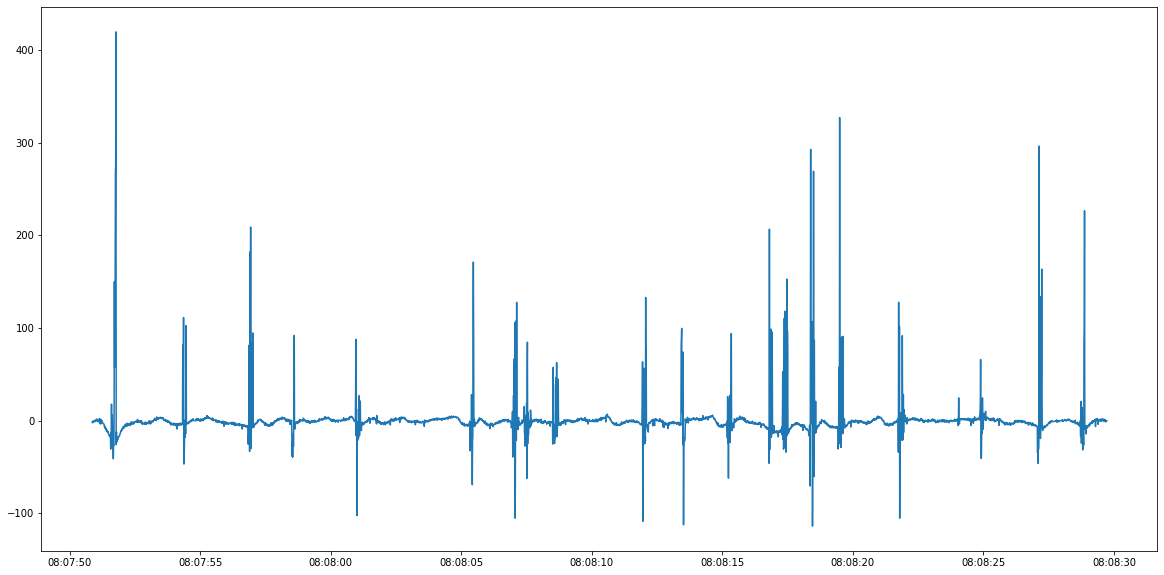

In [194]:
order = 1
cutoff = 0.5
normal_cutoff = 2*cutoff/fs
b, a = signal.butter(order, normal_cutoff, btype='highpass', analog=False)
y = signal.filtfilt(b, a, pupil_data[test_time_start:test_time_end]["pupil_size"].values)
plt.figure(figsize=(20,10))
plt.plot(pupil_data[test_time_start:test_time_end]["pupil_size"].index,y)

In [ ]:
order = 2
cutoff = 2
normal_cutoff = 2*cutoff/fs
b, a = signal.butter(order, normal_cutoff, btype='highpass', analog=False)
y = signal.filtfilt(b, a, pupil_data[test_time_start:test_time_end]["pupil_size"].values)
plt.figure(figsize=(20,10))
plt.plot(pupil_data[test_time_start:test_time_end]["pupil_size"].index,y)

## 将多有的trail平均后画图

## 绘制第1组的数据

### 0. 指定trail数据分割

In [32]:
def get_trail_segment(num):
    '''
    给定trail_num,返回分割后的pupil_data和pupil_event
    '''
    assert 1<= num <= trail_num, f"the legal trail_num between 1 and {trail_num},check the input "
    # 开始时间应该是trail的开始时间
    # 结束时间是下一个trail的开始时间
    temp = pupil_event.loc[num].index
    start_time,end_time = temp[0],temp[-1]
    # 筛选时间段
    ans_pupil_data  = pupil_data[start_time:end_time]
    ans_pupil_event  = pupil_event.loc[num]
    return ans_pupil_data,ans_pupil_event

In [98]:
# 截取第一个trail的数据
pupil_data_segment,pupil_event_segment = get_trail_segment(1)

In [101]:
pupil_event_segment

,message
timestamp,
2021-11-04 08:07:50.862,TRIALID 1
2021-11-04 08:07:52.364,!V TRIAL_VAR transitions variable
2021-11-04 08:07:52.865,!V TRIAL_VAR stake 5
2021-11-04 08:07:54.011,!E TRIAL_EVENT_VAR response_1
2021-11-04 08:07:54.872,!E TRIAL_EVENT_VAR monster_show
2021-11-04 08:07:55.396,!E TRIAL_EVENT_VAR response_2
2021-11-04 08:07:56.875,!E TRIAL_EVENT_VAR reward
2021-11-04 08:07:59.862,TRIAL_END


In [99]:
pupil_data_segment

,pupil_size,pupil_x,pupil_y
timestamp,,,
2021-11-04 08:07:50.865,95,1386.48,391.712
2021-11-04 08:07:50.875,96,1385.55,392.301
2021-11-04 08:07:50.885,97,1385.65,394.228
2021-11-04 08:07:50.895,97,1384.57,394.236
2021-11-04 08:07:50.905,96,1384.10,395.431
...,...,...,...
2021-11-04 08:07:59.815,104,1356.95,402.755
2021-11-04 08:07:59.825,104,1356.97,404.255
2021-11-04 08:07:59.835,103,1356.97,405.520


### 99999. 求统计指标

## !!!!!!important必须对数据滤波后才能求极差，不然效果很差

1. 指定区间的最大最小值
2. 指定区间的方差
3. 指定区间的极差

In [ ]:
interval